# Predict

In [1]:
import pandas as pd
from katlas.train import *
from katlas.dnn import *
from fastai.vision.all import *
from katlas.pssm import *

In [3]:
pspa_unk = pd.read_parquet('raw/kd_similar_pspa.parquet')
pspa_unk = pspa_unk[pspa_unk.within_threshold].copy()

In [4]:
len(pspa_unk)

1230

In [5]:
# from katlas.data import *

# kd = Data.get_kd_uniprot()

In [6]:
t5 = pd.read_parquet('raw/t5_kd.parquet')

In [7]:
test_pspa = t5.loc[pspa_unk.index].reset_index()

## Predict

In [8]:
sample=pd.read_parquet('train/pspa_t5.parquet')

In [9]:
target_col = sample.columns[~sample.columns.str.startswith('T5')]

In [10]:
target_col

Index(['-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P', '4P',
       ...
       '-5pY', '-4pY', '-3pY', '-2pY', '-1pY', '0pY', '1pY', '2pY', '3pY',
       '4pY'],
      dtype='object', length=230)

In [11]:
feat_col = test_pspa.columns[1:]

In [12]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

In [13]:
n_feature = len(feat_col)
n_target = len(target_col)

In [14]:
n_feature,n_target

(1024, 230)

In [15]:
def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

In [16]:
from tqdm import tqdm

In [17]:
def get_ensemble_pred(test_df, model_name,nfold=5):
    ensemble = None
    for i in tqdm(range(nfold)):
        test_pred = predict_dl(test_df, 
                   feat_col, 
                   target_col,
                   model_func=get_cnn, # model architecture
                   model_pth=f'{model_name}_fold{i}', # only name, not with .pth
                  )
        if ensemble is None:
            ensemble = test_pred.copy()   # start with first prediction
        else:
            ensemble += test_pred         # accumulate
    
    ensemble /= 5
    return ensemble

In [18]:
pred = get_ensemble_pred(test_pspa,'cnn_pspa')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


In [19]:
pred.index=pspa_unk.index

In [24]:
pred.to_parquet('raw/pred_new_pspa.parquet')

In [25]:
pred

,-5P,-4P,-3P,-2P,-1P,0P,1P,2P,3P,4P,...,-5pY,-4pY,-3pY,-2pY,-1pY,0pY,1pY,2pY,3pY,4pY
A0A8I3S724_AURKA_CANLF_KD1,0.037882,0.043779,0.047041,0.015380,0.041898,0.000035,0.014323,0.038704,0.043827,0.049526,...,0.044010,0.040576,0.037645,0.013764,0.059714,3.364276e-06,0.038454,0.043046,0.061429,0.046730
A0A8I5ZNK2_OXSR1_RAT_KD1,0.049239,0.043381,0.043311,0.028526,0.024280,0.000017,0.015904,0.036569,0.055815,0.055253,...,0.056746,0.050559,0.046230,0.048480,0.063029,1.908836e-06,0.024791,0.022593,0.038125,0.032603
A0JM20_TYRO3_XENTR_KD1,0.051376,0.052102,0.052074,0.052638,0.039458,0.000007,0.014260,0.036449,0.041221,0.043479,...,0.047453,0.048676,0.052394,0.046324,0.091800,9.998582e-01,0.070185,0.070169,0.022106,0.042790
A0JNB0_FYN_BOVIN_KD1,0.046870,0.045461,0.040785,0.051638,0.031777,0.000042,0.014092,0.031362,0.044332,0.045642,...,0.053741,0.067277,0.067271,0.058158,0.079825,9.992056e-01,0.115731,0.104918,0.031915,0.042396
A0M8R7_MET_PAPAN_KD1,0.050430,0.051898,0.046124,0.052797,0.030787,0.000008,0.012470,0.035201,0.051783,0.045867,...,0.055322,0.063184,0.067201,0.055751,0.128271,9.998606e-01,0.096431,0.081910,0.025833,0.041041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2R9_E2AK1_MOUSE_KD1,0.034602,0.038246,0.029201,0.018279,0.023267,0.000089,0.006634,0.026299,0.060636,0.040961,...,0.036762,0.033087,0.052582,0.034784,0.052302,4.450690e-07,0.022007,0.019414,0.033284,0.040663
Q9Z2W1_STK25_MOUSE_KD1,0.045502,0.040996,0.040295,0.032663,0.030100,0.000020,0.017534,0.042085,0.043391,0.050217,...,0.042046,0.036751,0.047517,0.044899,0.036057,3.428805e-06,0.019266,0.016506,0.029094,0.024208
Q9Z335_SBK1_RAT_KD1,0.040285,0.027252,0.026376,0.035437,0.108038,0.000049,0.061123,0.050412,0.066567,0.059834,...,0.026251,0.025690,0.013364,0.027668,0.028979,1.546801e-06,0.043730,0.041582,0.060285,0.045016
W0LYS5_CAMKI_MACNP_KD1,0.049159,0.035515,0.025772,0.020806,0.057251,0.000065,0.014600,0.028858,0.027823,0.049323,...,0.028890,0.024585,0.017603,0.015780,0.031326,4.352188e-06,0.035301,0.101816,0.042666,0.032528


## test

In [21]:
cdks = pspa_unk[pspa_unk.closest_pos_index.str.contains('CDK')]

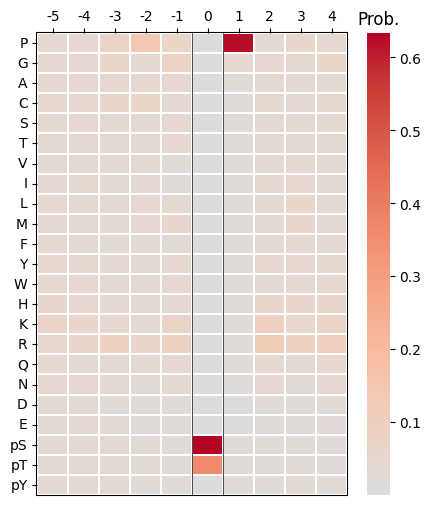

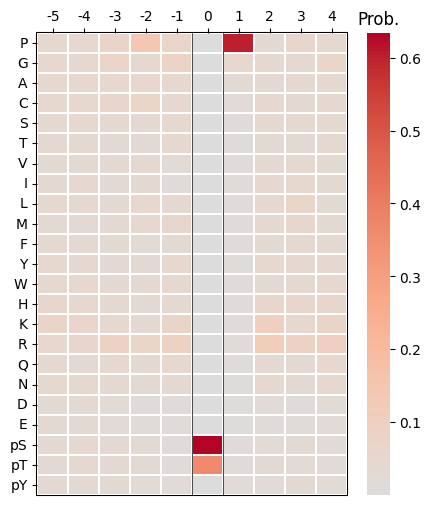

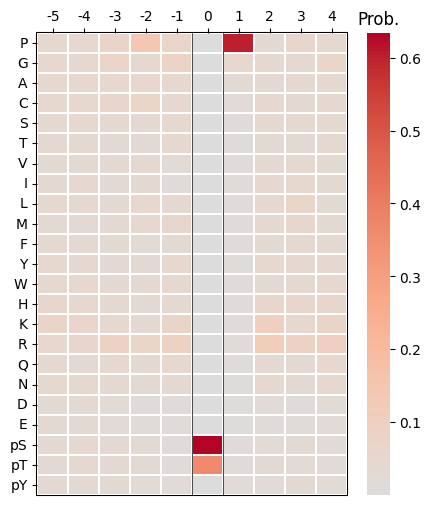

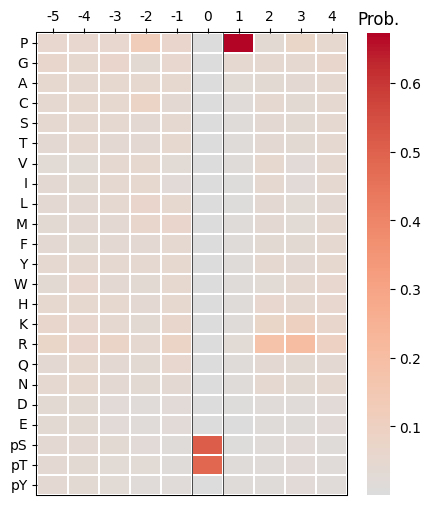

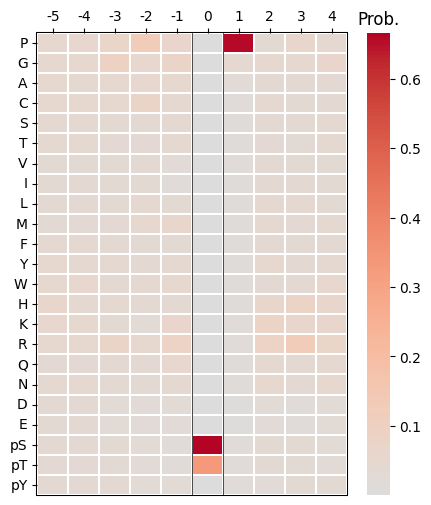

In [23]:
for i in cdks.head(5).index:
    plot_heatmap(recover_pssm(pred.loc[i]))
    plt.show()
    plt.close()